# FEUP - AC
## Banking - Predicting a Loan Outcome

### Business understanding

##### Analysis of requirements with the end user
Text

##### Definition of business goals
Text

##### Translation of business goals into data mining goals
Text

### Exploratory data analysis

Let us start by importing the datasets.

In [123]:
import pandas as pd
import numpy as np

# Global settings
pd.set_option('display.max_columns', None)

COMP_DATA_SOURCE = "comp_data/"
DEV_DATA_SOURCE = "dev_data/"

# Read in the data; merge data for tables other than loans since they do not influence merges
accounts = pd.read_csv(DEV_DATA_SOURCE + 'account.csv', sep=';')

cards_dev = pd.read_csv(DEV_DATA_SOURCE + 'card.csv', sep=';')
cards_comp = pd.read_csv(COMP_DATA_SOURCE + 'card.csv', sep=';')
cards = pd.concat([cards_dev, cards_comp])

clients = pd.read_csv(DEV_DATA_SOURCE + 'client.csv', sep=';')

dispositions = pd.read_csv(DEV_DATA_SOURCE + 'disp.csv', sep=';')

districts = pd.read_csv(DEV_DATA_SOURCE + 'district.csv', sep=';')

transactions_dev = pd.read_csv(DEV_DATA_SOURCE + 'trans.csv', sep=';')
transactions_comp = pd.read_csv(COMP_DATA_SOURCE + 'trans.csv', sep=';')
transactions = pd.concat([transactions_dev, transactions_comp])

loans_dev = pd.read_csv(DEV_DATA_SOURCE + 'loan.csv', sep=';')
loans_comp = pd.read_csv(COMP_DATA_SOURCE + 'loan.csv', sep=';')

loans_dev.head()

C:\Users\joaoj\AppData\Local\Temp\ipykernel_38420\482001259.py:23: DtypeWarning: Columns (8) have mixed types. Specify dtype option on import or set low_memory=False.
  transactions_dev = pd.read_csv(DEV_DATA_SOURCE + 'trans.csv', sep=';')


,loan_id,account_id,date,amount,duration,payments,status
0,5314,1787,930705,96396,12,8033,-1
1,5316,1801,930711,165960,36,4610,1
2,6863,9188,930728,127080,60,2118,1
3,5325,1843,930803,105804,36,2939,1
4,7240,11013,930906,274740,60,4579,1


Plenty of analysis with graphs, distributions, outliers...

### Data preprocessing

Text

#### Processing accounts

The account spreadsheet relates it with the district and date in which it was created, as well with the frequency of issuance of statements with the owner.

The date comes in the from YYMMDD, which is easily extractable to the three different columns that it is aggregating. This will aid the model in detecting important patterns in the year of creation, for example, indicating a global economic crisis or prosperity when the person has created the account.

In [124]:
import src.preprocess.accounts as accpp
accounts = accpp.preprocess_accounts(accounts)
accounts.head()

,account_id,district_id,account_frequency,account_year,account_month,account_day
0,576,55,monthly issuance,93,1,1
1,3818,74,monthly issuance,93,1,1
2,704,55,monthly issuance,93,1,1
3,2378,16,monthly issuance,93,1,1
4,2632,24,monthly issuance,93,1,2


#### Processing credit cards

In the credit cards relation, the same concept applies to the date of issuance.

MORE TEXT

In [125]:
from src.preprocess.cards import preprocess_cards

cards = preprocess_cards(cards)
cards.head()

,card_id,disp_id,type,year,month,day
0,1005,9285,classic,93,11,7
1,104,588,classic,94,1,19
2,747,4915,classic,94,2,5
3,70,439,classic,94,2,8
4,577,3687,classic,94,2,15


#### Processing clients

In the clients relation, two foreign references and a date appear once again. However, regarding the latter one, there is an important difference: the day is the actual day plus fifty, if the client is a female, and so we can extract the gender too, here.

In [126]:
from src.preprocess.clients import preprocess_clients

clients = preprocess_clients(clients)
clients.head()

,client_id,district_id,year,month,day,gender
0,1,18,70,12,13,female
1,2,1,45,2,4,male
2,3,1,40,10,9,female
3,4,5,56,12,1,male
4,5,5,60,7,3,female


#### Processing dispositions

The disposition describes the rights of clients to operate accounts: only "owners" can ask for loans and issue permanent orders.

There is no clear way to merge this table with loans later on, since the loans table does not refer the disposition used for the loan. Instead, let's focus on the number of dispositions and the ratio of owners of an account, which will give an impression of the nature of the people able to control the account. All humans fight and cheat on each other, or build trust together. Let's discover that pattern in Czech Republic.

In [127]:
from src.preprocess.dispositions import preprocess_dispositions
dispositions = preprocess_dispositions(dispositions)
dispositions.head()

,disp_id,client_id,account_id,type,number_account_dispositions
0,1,1,1,OWNER,1
1,2,2,2,OWNER,2
2,3,3,2,DISPONENT,2
3,4,4,3,OWNER,2
4,5,5,3,DISPONENT,2


#### Processing districts

The districts relation is quite dense, describing the demographic data of a region. We can extract interesting measures here:

- The commited crimes growth ratio, derived from the evolution of the number of crimes from '95 to '96
- The unemployment rate growth ratio, derived from the evolution of the employment rate from '95 to '96

We also acknowledged that there was one region where the number of crimes and unemployment rate in '95 was not known (`?` was the appearance in the respective column). In order not to discard the entire region data, we'll simply assume that number to be the same as the matching record in '96.

In [128]:
from src.preprocess.districts import preprocess_districts
districts = preprocess_districts(districts)
districts.head()

,district_id,district_no_inhabitants,district_no_cities,district_urban_inhabitants_ratio,district_average_salary,district_unemployment_rate,districts_entrepreneurs_ratio,district_crimes_per_inhabitant,district_crime_growth,district_unemploymant_growth
0,1,1204953,1,100.0,12541,0.43,0.167,0.082250,1.156752,1.482759
1,2,88884,5,46.7,8507,1.85,0.132,0.030084,1.238536,1.107784
2,3,75232,5,41.7,8980,2.21,0.111,0.037391,0.996105,1.133333
3,4,149893,6,67.4,9753,5.05,0.109,0.039308,1.123570,1.088362
4,5,95616,6,51.4,9307,4.43,0.118,0.031794,1.162080,1.150649


#### Processing loans

The loans relation references an account and the date of loan, which can be extracted. The duration seems to be in months, so let us improve the name of the column. The amounts seems to be in `Czech korunas`, the czech currency, as hinted by the list of regions; we'll convert it to euros for better visualization and understanding of the upcoming results.

In [129]:
from src.preprocess.loans import preprocess_loans
loans_comp = preprocess_loans(loans_comp)
loans_dev = preprocess_loans(loans_dev)
loans_dev.head()

,loan_id,account_id,amount,duration_months,monthly_payment,status,year,month,day
0,5314,1787,3950.66,12,329.22,-1,93,7,5
1,5316,1801,6801.64,36,188.93,1,93,7,11
2,6863,9188,5208.20,60,86.80,1,93,7,28
3,5325,1843,4336.23,36,120.45,1,93,8,3
4,7240,11013,11259.84,60,187.66,1,93,9,6


#### Processing transactions

This table contains a lot of information that we cannot directly relate to a loan.

Let us first extract the date and make the withdrawal amounts actually negative, to give the model an impression of the direction of the money flow in and out of the bank.

For now, let us extract some statistical data related to the accounts, which we'll relate to the loans table.

In [130]:
from src.preprocess.transactions import preprocess_transactions
transactions = preprocess_transactions(transactions)
transactions.head()

,trans_id,account_id,type,operation,amount,balance,k_symbol,bank,account,year,month,day
0,1548749,5270,credit,credit in cash,32.79,32.79,NaN,NaN,NaN,93,1,13
1,1548750,5270,credit,collection from another bank,1833.98,1866.76,NaN,IJ,80269753.0,93,1,14
2,3393738,11265,credit,credit in cash,40.98,40.98,NaN,NaN,NaN,93,1,14
3,3122924,10364,credit,credit in cash,45.08,45.08,NaN,NaN,NaN,93,1,17
4,1121963,3834,credit,credit in cash,28.69,28.69,NaN,NaN,NaN,93,1,19


#### Feature engineering

Text

##### Getting the average account balance based on the transactions

In [131]:
from src.feature_engineering.merge import merge_account_transactions
accounts = merge_account_transactions(accounts, transactions)
accounts.head()

,account_id,district_id,account_frequency,account_year,account_month,account_day,account_average_balance
0,576,55,monthly issuance,93,1,1,995.213406
1,3818,74,monthly issuance,93,1,1,1755.200383
2,704,55,monthly issuance,93,1,1,1424.108906
3,2378,16,monthly issuance,93,1,1,2376.927362
4,2632,24,monthly issuance,93,1,2,1326.053913


##### Clusters

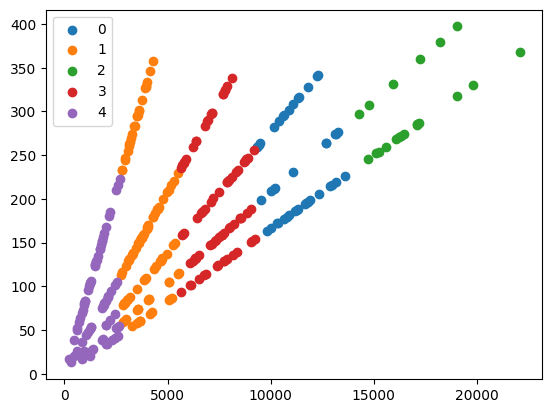

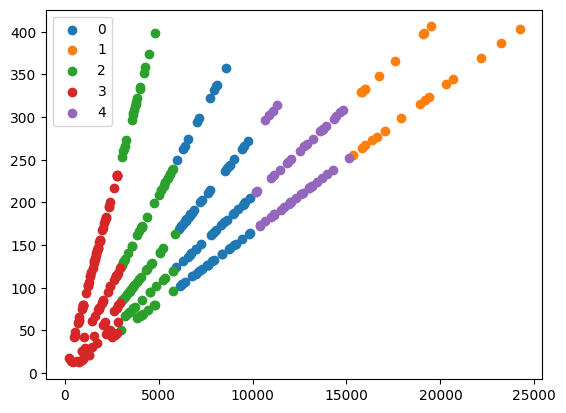

In [132]:
import src.stats.clusters as clusters
clusters.cluster_monthly_payment_per_loan_amount(loans_dev)
clusters.cluster_monthly_payment_per_loan_amount(loans_comp)

In [133]:
table = clusters.cluster_transactions(transactions)
accounts = pd.merge(accounts, table, on='account_id', how='left')
accounts.head()

(3724, 10)


,account_id,district_id,account_frequency,account_year,account_month,account_day,account_average_balance,transaction_profile
0,576,55,monthly issuance,93,1,1,995.213406,2
1,3818,74,monthly issuance,93,1,1,1755.200383,5
2,704,55,monthly issuance,93,1,1,1424.108906,5
3,2378,16,monthly issuance,93,1,1,2376.927362,3
4,2632,24,monthly issuance,93,1,2,1326.053913,5


#### Merging the data

The model will be working on the `loans` table, since the target variable belongs to it. The one foreign key of that table is `account_id`; so, to feed the model with more information about the context of the loan, we should relate concepts to the account for each table.

##### Relating clients to districts

In [134]:
import src.feature_engineering.merge as merge

clients = merge.merge_client_districts(clients, districts)
clients.head()

,client_id,year,month,day,gender,owner_district_no_inhabitants,owner_district_no_cities,owner_district_urban_inhabitants_ratio,owner_district_average_salary,owner_district_unemployment_rate,owner_districts_entrepreneurs_ratio,owner_district_crimes_per_inhabitant,owner_district_crime_growth,owner_district_unemploymant_growth
0,1,70,12,13,female,70699,4,65.3,8968,3.35,0.131,0.027016,1.097701,1.183746
1,2,45,2,4,male,1204953,1,100.0,12541,0.43,0.167,0.082250,1.156752,1.482759
2,3,40,10,9,female,1204953,1,100.0,12541,0.43,0.167,0.082250,1.156752,1.482759
3,4,56,12,1,male,95616,6,51.4,9307,4.43,0.118,0.031794,1.162080,1.150649
4,5,60,7,3,female,95616,6,51.4,9307,4.43,0.118,0.031794,1.162080,1.150649


##### Relating dispositions to clients

In [135]:
dispositions = merge.merge_dispositions_clients(dispositions, clients)
dispositions.head()

,disp_id,account_id,type,number_account_dispositions,client_year,client_month,client_day,client_gender,owner_district_no_inhabitants,owner_district_no_cities,owner_district_urban_inhabitants_ratio,owner_district_average_salary,owner_district_unemployment_rate,owner_districts_entrepreneurs_ratio,owner_district_crimes_per_inhabitant,owner_district_crime_growth,owner_district_unemploymant_growth
0,1,1,OWNER,1,70,12,13,female,70699,4,65.3,8968,3.35,0.131,0.027016,1.097701,1.183746
1,2,2,OWNER,2,45,2,4,male,1204953,1,100.0,12541,0.43,0.167,0.082250,1.156752,1.482759
2,3,2,DISPONENT,2,40,10,9,female,1204953,1,100.0,12541,0.43,0.167,0.082250,1.156752,1.482759
3,4,3,OWNER,2,56,12,1,male,95616,6,51.4,9307,4.43,0.118,0.031794,1.162080,1.150649
4,5,3,DISPONENT,2,60,7,3,female,95616,6,51.4,9307,4.43,0.118,0.031794,1.162080,1.150649


##### Relating dispositions to cards

In [136]:
dispositions_cpy = merge.merge_dispositions_cards(dispositions, cards) # cards are not enough; too many nans, check and discard
dispositions_cpy.head()

,disp_id,account_id,type,number_account_dispositions,client_year,client_month,client_day,client_gender,owner_district_no_inhabitants,owner_district_no_cities,owner_district_urban_inhabitants_ratio,owner_district_average_salary,owner_district_unemployment_rate,owner_districts_entrepreneurs_ratio,owner_district_crimes_per_inhabitant,owner_district_crime_growth,owner_district_unemploymant_growth,card_type,card_year,card_month,card_day
0,1,1,OWNER,1,70,12,13,female,70699,4,65.3,8968,3.35,0.131,0.027016,1.097701,1.183746,NaN,NaN,NaN,NaN
1,2,2,OWNER,2,45,2,4,male,1204953,1,100.0,12541,0.43,0.167,0.082250,1.156752,1.482759,NaN,NaN,NaN,NaN
2,3,2,DISPONENT,2,40,10,9,female,1204953,1,100.0,12541,0.43,0.167,0.082250,1.156752,1.482759,NaN,NaN,NaN,NaN
3,4,3,OWNER,2,56,12,1,male,95616,6,51.4,9307,4.43,0.118,0.031794,1.162080,1.150649,NaN,NaN,NaN,NaN
4,5,3,DISPONENT,2,60,7,3,female,95616,6,51.4,9307,4.43,0.118,0.031794,1.162080,1.150649,NaN,NaN,NaN,NaN


##### Relating owner dispositions to accounts

Only owners can ask for loans. This way, we can directly relate an account to its owner client.

In [137]:
accounts = merge.merge_account_dispositions(accounts, dispositions)
accounts.head()

,account_id,district_id,account_frequency,account_year,account_month,account_day,account_average_balance,transaction_profile,number_account_dispositions,owner_year,owner_month,owner_day,owner_gender,owner_district_no_inhabitants,owner_district_no_cities,owner_district_urban_inhabitants_ratio,owner_district_average_salary,owner_district_unemployment_rate,owner_districts_entrepreneurs_ratio,owner_district_crimes_per_inhabitant,owner_district_crime_growth,owner_district_unemploymant_growth
0,576,55,monthly issuance,93,1,1,995.213406,2,2,36,1,11,female,323870,1,100.0,10673,5.44,0.100,0.056649,0.976840,1.145263
1,3818,74,monthly issuance,93,1,1,1755.200383,5,2,35,4,2,male,1204953,1,100.0,12541,0.43,0.167,0.082250,1.156752,1.482759
2,704,55,monthly issuance,93,1,1,1424.108906,5,2,45,1,14,male,58400,6,52.4,8620,1.25,0.100,0.019127,1.025712,1.136364
3,2378,16,monthly issuance,93,1,1,2376.927362,3,1,75,3,24,female,93931,8,56.9,8427,1.54,0.107,0.020366,1.020811,1.375000
4,2632,24,monthly issuance,93,1,2,1326.053913,5,1,38,8,12,male,122603,8,80.0,8991,2.01,0.128,0.043009,1.014429,1.446043


##### Relating accounts with district data

Text

In [138]:
accounts = merge.merge_accounts_districts(accounts, districts)
accounts.head()

,account_id,account_frequency,account_year,account_month,account_day,account_average_balance,transaction_profile,number_account_dispositions,owner_year,owner_month,owner_day,owner_gender,owner_district_no_inhabitants,owner_district_no_cities,owner_district_urban_inhabitants_ratio,owner_district_average_salary,owner_district_unemployment_rate,owner_districts_entrepreneurs_ratio,owner_district_crimes_per_inhabitant,owner_district_crime_growth,owner_district_unemploymant_growth,account_district_no_inhabitants,account_district_no_cities,account_district_urban_inhabitants_ratio,account_district_average_salary,account_district_unemployment_rate,account_districts_entrepreneurs_ratio,account_district_crimes_per_inhabitant,account_district_crime_growth,account_district_unemploymant_growth
0,576,monthly issuance,93,1,1,995.213406,2,2,36,1,11,female,323870,1,100.0,10673,5.44,0.100,0.056649,0.976840,1.145263,157042,9,33.9,8743,2.43,0.111,0.024796,1.064225,1.292553
1,3818,monthly issuance,93,1,1,1755.200383,5,2,35,4,2,male,1204953,1,100.0,12541,0.43,0.167,0.082250,1.156752,1.482759,323870,1,100.0,10673,5.44,0.100,0.056649,0.976840,1.145263
2,704,monthly issuance,93,1,1,1424.108906,5,2,45,1,14,male,58400,6,52.4,8620,1.25,0.100,0.019127,1.025712,1.136364,157042,9,33.9,8743,2.43,0.111,0.024796,1.064225,1.292553
3,2378,monthly issuance,93,1,1,2376.927362,3,1,75,3,24,female,93931,8,56.9,8427,1.54,0.107,0.020366,1.020811,1.375000,93931,8,56.9,8427,1.54,0.107,0.020366,1.020811,1.375000
4,2632,monthly issuance,93,1,2,1326.053913,5,1,38,8,12,male,122603,8,80.0,8991,2.01,0.128,0.043009,1.014429,1.446043,122603,8,80.0,8991,2.01,0.128,0.043009,1.014429,1.446043


##### Loading the loans table with data

In [139]:
accounts.rename(columns = {'year':'account_year', 'month':'account_month', 'day':'account_day', 'frequency': 'account_frequency', 'district_id': 'account_district_id'}, inplace=True)
loans_dev = loans_dev.merge(accounts, on="account_id", how="left")
loans_comp = loans_comp.merge(accounts, on="account_id", how="left")
loans_dev.drop(columns=['account_id'], inplace=True)
loans_comp.drop(columns=['account_id'], inplace=True)
loans_dev.head()

# merge with disp with card
# merge disp with account
# merge stuff

,loan_id,amount,duration_months,monthly_payment,status,year,month,day,loan_profile,account_frequency,account_year,account_month,account_day,account_average_balance,transaction_profile,number_account_dispositions,owner_year,owner_month,owner_day,owner_gender,owner_district_no_inhabitants,owner_district_no_cities,owner_district_urban_inhabitants_ratio,owner_district_average_salary,owner_district_unemployment_rate,owner_districts_entrepreneurs_ratio,owner_district_crimes_per_inhabitant,owner_district_crime_growth,owner_district_unemploymant_growth,account_district_no_inhabitants,account_district_no_cities,account_district_urban_inhabitants_ratio,account_district_average_salary,account_district_unemployment_rate,account_districts_entrepreneurs_ratio,account_district_crimes_per_inhabitant,account_district_crime_growth,account_district_unemploymant_growth
0,5314,3950.66,12,329.22,-1,93,7,5,1,weekly issuance,93,3,22,502.047500,6,1,47,7,22,female,94812,10,81.8,9650,3.67,0.100,0.029574,0.939363,1.085799,94812,10,81.8,9650,3.67,0.100,0.029574,0.939363,1.085799
1,5316,6801.64,36,188.93,1,93,7,11,3,monthly issuance,93,2,13,2134.584324,6,1,68,7,22,male,112709,10,73.5,8369,2.31,0.117,0.023228,0.917309,1.290503,112709,10,73.5,8369,2.31,0.117,0.023228,0.917309,1.290503
2,6863,5208.20,60,86.80,1,93,7,28,1,monthly issuance,93,2,8,1232.007083,6,1,36,6,2,male,77917,5,53.5,8390,2.89,0.132,0.027234,1.020192,1.267544,77917,5,53.5,8390,2.89,0.132,0.027234,1.020192,1.267544
3,5325,4336.23,36,120.45,1,93,8,3,1,monthly issuance,93,1,30,1692.519600,6,1,40,4,20,female,177686,9,74.8,10045,1.71,0.135,0.035428,0.953210,1.204225,107870,6,58.0,8754,4.31,0.137,0.035858,1.016824,1.125326
4,7240,11259.84,60,187.66,1,93,9,6,0,weekly issuance,93,2,14,2343.778889,6,1,78,9,7,male,86513,5,50.5,8288,4.52,0.110,0.016876,0.934699,1.192612,1204953,1,100.0,12541,0.43,0.167,0.082250,1.156752,1.482759


##### Replace account data with ranges

In [140]:
import src.preprocess.util as utils
#loans_dev = utils.account_date_to_levels(loans_dev)
#loans_comp = utils.account_date_to_levels(loans_comp)
#loans_dev.head()

##### Feature selection on the loans table

In [141]:
#loans_dev = loans_dev.drop(columns=["account_id","district_no_cities", "district_crime_growth"])
#loans_comp = loans_comp.drop(columns=["account_id","district_no_cities", "district_crime_growth"])

#loans_dev = loans_dev.drop(columns=["account_id", "district_no_cities"])
#loans_comp = loans_comp.drop(columns=["account_id", "district_no_cities"])

loans_dev.head(10)

,loan_id,amount,duration_months,monthly_payment,status,year,month,day,loan_profile,account_frequency,account_year,account_month,account_day,account_average_balance,transaction_profile,number_account_dispositions,owner_year,owner_month,owner_day,owner_gender,owner_district_no_inhabitants,owner_district_no_cities,owner_district_urban_inhabitants_ratio,owner_district_average_salary,owner_district_unemployment_rate,owner_districts_entrepreneurs_ratio,owner_district_crimes_per_inhabitant,owner_district_crime_growth,owner_district_unemploymant_growth,account_district_no_inhabitants,account_district_no_cities,account_district_urban_inhabitants_ratio,account_district_average_salary,account_district_unemployment_rate,account_districts_entrepreneurs_ratio,account_district_crimes_per_inhabitant,account_district_crime_growth,account_district_unemploymant_growth
0,5314,3950.66,12,329.22,-1,93,7,5,1,weekly issuance,93,3,22,502.047500,6,1,47,7,22,female,94812,10,81.8,9650,3.67,0.100,0.029574,0.939363,1.085799,94812,10,81.8,9650,3.67,0.100,0.029574,0.939363,1.085799
1,5316,6801.64,36,188.93,1,93,7,11,3,monthly issuance,93,2,13,2134.584324,6,1,68,7,22,male,112709,10,73.5,8369,2.31,0.117,0.023228,0.917309,1.290503,112709,10,73.5,8369,2.31,0.117,0.023228,0.917309,1.290503
2,6863,5208.20,60,86.80,1,93,7,28,1,monthly issuance,93,2,8,1232.007083,6,1,36,6,2,male,77917,5,53.5,8390,2.89,0.132,0.027234,1.020192,1.267544,77917,5,53.5,8390,2.89,0.132,0.027234,1.020192,1.267544
3,5325,4336.23,36,120.45,1,93,8,3,1,monthly issuance,93,1,30,1692.519600,6,1,40,4,20,female,177686,9,74.8,10045,1.71,0.135,0.035428,0.953210,1.204225,107870,6,58.0,8754,4.31,0.137,0.035858,1.016824,1.125326
4,7240,11259.84,60,187.66,1,93,9,6,0,weekly issuance,93,2,14,2343.778889,6,1,78,9,7,male,86513,5,50.5,8288,4.52,0.110,0.016876,0.934699,1.192612,1204953,1,100.0,12541,0.43,0.167,0.082250,1.156752,1.482759
5,6687,3600.00,24,150.00,1,93,9,13,1,monthly issuance,93,5,12,1898.301176,6,2,80,2,16,female,53921,2,41.3,8598,3.26,0.123,0.034773,1.174076,1.176895,53921,2,41.3,8598,3.26,0.123,0.034773,1.174076,1.176895
6,7284,2163.44,12,180.29,1,93,9,15,4,monthly issuance,93,1,14,909.761163,1,1,73,2,16,male,58796,5,51.9,9045,3.60,0.124,0.031958,1.018428,1.150160,58796,5,51.9,9045,3.60,0.124,0.031958,1.018428,1.150160
7,6111,7161.64,24,298.40,-1,93,9,24,3,monthly issuance,93,4,14,1536.289062,6,1,48,8,12,female,122603,8,80.0,8991,2.01,0.128,0.043009,1.014429,1.446043,122603,8,80.0,8991,2.01,0.128,0.043009,1.014429,1.446043
8,7235,6328.52,48,131.84,1,93,10,13,3,weekly issuance,93,4,20,1914.580937,6,1,69,5,25,female,70699,4,65.3,8968,3.35,0.131,0.027016,1.097701,1.183746,70699,4,65.3,8968,3.35,0.131,0.027016,1.097701,1.183746
9,5997,4796.07,24,199.84,1,93,11,4,1,monthly issuance,93,6,20,1808.654615,6,1,35,10,3,male,177686,9,74.8,10045,1.71,0.135,0.035428,0.953210,1.204225,177686,9,74.8,10045,1.71,0.135,0.035428,0.953210,1.204225


##### Feature engineering on the loans table

In [194]:
def extract_age(owner_birth, loan_date):
	(owner_year, owner_month, owner_day) = owner_birth
	(loan_year, loan_month, loan_day) = loan_date
	owner_age = -1
	if owner_year <= loan_year:
		owner_age = loan_year - owner_year
		if owner_month == loan_month:
			if owner_day > loan_day:
				owner_age =- 1
		elif owner_month != loan_month:
			if owner_month > loan_month:
				owner_age =- 1
		owner_age = -1
		print("incorrect owner_year !")
    return owner_age

# extract owner age from loan date and owner birthdate 
age_column = []
for index in loans_dev.index:
    owner_birth = (loans_dev.iloc[index]['owner_year'], loans_dev.iloc[index]['owner_month'], loans_dev.iloc[index]['owner_day'])
    loan_date = (loans_dev.iloc[index]['year'], loans_dev.iloc[index]['month'], loans_dev.iloc[index]['day'])

    owner_age = extract_age(owner_birth, loan_date)
    print(owner_age)
    age_column.append(owner_age)

loans_dev['age_at_loan'] = age_column
loans_dev.head(5)

IndentationError: unindent does not match any outer indentation level (<tokenize>, line 4)

### Training the model

Text

In [142]:
for col in loans_dev.columns:
    print(col)

print(len(loans_dev.columns) == len(loans_comp.columns))

loans_dev = utils.extract_categorical(loans_dev, "account_frequency")
loans_comp = utils.extract_categorical(loans_comp, "account_frequency")
loans_dev = utils.extract_categorical(loans_dev, "owner_gender")
loans_comp = utils.extract_categorical(loans_comp, "owner_gender")

loans_dev.head()

loan_id
amount
duration_months
monthly_payment
status
year
month
day
loan_profile
account_frequency
account_year
account_month
account_day
account_average_balance
transaction_profile
number_account_dispositions
owner_year
owner_month
owner_day
owner_gender
owner_district_no_inhabitants
owner_district_no_cities
owner_district_urban_inhabitants_ratio
owner_district_average_salary
owner_district_unemployment_rate
owner_districts_entrepreneurs_ratio
owner_district_crimes_per_inhabitant
owner_district_crime_growth
owner_district_unemploymant_growth
account_district_no_inhabitants
account_district_no_cities
account_district_urban_inhabitants_ratio
account_district_average_salary
account_district_unemployment_rate
account_districts_entrepreneurs_ratio
account_district_crimes_per_inhabitant
account_district_crime_growth
account_district_unemploymant_growth
True


,loan_id,amount,duration_months,monthly_payment,status,year,month,day,loan_profile,account_year,account_month,account_day,account_average_balance,transaction_profile,number_account_dispositions,owner_year,owner_month,owner_day,owner_district_no_inhabitants,owner_district_no_cities,owner_district_urban_inhabitants_ratio,owner_district_average_salary,owner_district_unemployment_rate,owner_districts_entrepreneurs_ratio,owner_district_crimes_per_inhabitant,owner_district_crime_growth,owner_district_unemploymant_growth,account_district_no_inhabitants,account_district_no_cities,account_district_urban_inhabitants_ratio,account_district_average_salary,account_district_unemployment_rate,account_districts_entrepreneurs_ratio,account_district_crimes_per_inhabitant,account_district_crime_growth,account_district_unemploymant_growth,issuance after transaction,monthly issuance,weekly issuance,female,male
0,5314,3950.66,12,329.22,-1,93,7,5,1,93,3,22,502.047500,6,1,47,7,22,94812,10,81.8,9650,3.67,0.100,0.029574,0.939363,1.085799,94812,10,81.8,9650,3.67,0.100,0.029574,0.939363,1.085799,0,0,1,1,0
1,5316,6801.64,36,188.93,1,93,7,11,3,93,2,13,2134.584324,6,1,68,7,22,112709,10,73.5,8369,2.31,0.117,0.023228,0.917309,1.290503,112709,10,73.5,8369,2.31,0.117,0.023228,0.917309,1.290503,0,1,0,0,1
2,6863,5208.20,60,86.80,1,93,7,28,1,93,2,8,1232.007083,6,1,36,6,2,77917,5,53.5,8390,2.89,0.132,0.027234,1.020192,1.267544,77917,5,53.5,8390,2.89,0.132,0.027234,1.020192,1.267544,0,1,0,0,1
3,5325,4336.23,36,120.45,1,93,8,3,1,93,1,30,1692.519600,6,1,40,4,20,177686,9,74.8,10045,1.71,0.135,0.035428,0.953210,1.204225,107870,6,58.0,8754,4.31,0.137,0.035858,1.016824,1.125326,0,1,0,1,0
4,7240,11259.84,60,187.66,1,93,9,6,0,93,2,14,2343.778889,6,1,78,9,7,86513,5,50.5,8288,4.52,0.110,0.016876,0.934699,1.192612,1204953,1,100.0,12541,0.43,0.167,0.082250,1.156752,1.482759,0,0,1,0,1


#### Splitting the data for training

Text

In [143]:
from src.model.model import train_test_split_unbalanced
print(loans_dev.shape)
x_train, x_test, y_train, y_test = train_test_split_unbalanced(loans_dev, "status", sampling_strategy="smote_enn", sort_by_date=False, train_ratio=0.8)
print(x_train.shape)

(328, 41)
(268, 40)


#### Predicting and evaluating

Evaluate classification model performance with loans table

code the categorical feature into multiple binary features to allow the model to work!! (TBD)

In [144]:
from sklearn.ensemble import RandomForestClassifier
from sklearn.metrics import recall_score, accuracy_score, precision_score, f1_score, roc_auc_score
from src.model.model import self_confidence_score

# Create a Random Forest Model
random_classifier = RandomForestClassifier(n_estimators=50, random_state=0)

# Train it with data
random_classifier.fit(x_train, y_train)

if len(y_test) > 0: # not training with entire dataset
    # Predict the test data for dev and evaluate
    predictions_dev = random_classifier.predict(x_test)
    predictions_dev_prob = random_classifier.predict_proba(x_test)

    # Evaluate
    print('Recall: ', recall_score(y_test, predictions_dev, pos_label=-1))
    print('Accuracy: ', accuracy_score(y_test, predictions_dev))
    print('Precision: ', precision_score(y_test, predictions_dev))
    print('F-Score: ', f1_score(y_test, predictions_dev))
    print("AUROC: ", roc_auc_score(y_test, predictions_dev_prob[:, 1]))
    print("Self_confidence_score: ", self_confidence_score(predictions_dev_prob[:, 1]))

    # Write the dev predictions to a file
    predictions_dev_id = x_test["loan_id"]
    predictions_dev_debt = [x[0] for x in predictions_dev_prob]
    predictions_df_dev = pd.DataFrame({"Id": predictions_dev_id, "Predicted": predictions_dev_debt, "Actual": y_test})
    predictions_df_dev.to_csv("output/predictions_dev.csv", index=False)

# Predict the competition data with probabilities
loans_comp_indep = loans_comp.drop(axis=1, columns=["status"])
predictions_comp_prob = random_classifier.predict_proba(loans_comp_indep).tolist()
predictions_comp = random_classifier.predict(loans_comp_indep)

# Write the comp predictions to a file
predictions_comp_debt = [x[0] for x in predictions_comp_prob]
predictions_comp_id = loans_comp["loan_id"].tolist()
predictions_df_comp = pd.DataFrame({"Id": predictions_comp_id, "Predicted": predictions_comp_debt})
predictions_df_comp.to_csv("output/predictions_comp.csv", index=False)

Recall:  1.0
Accuracy:  0.9850746268656716
Precision:  1.0
F-Score:  0.9841269841269841
AUROC:  0.9959821428571428
Self_confidence_score:  0.7122388059701493


### Experimenting with other models

In [145]:
# Fit Naive Bayes to the training set

from sklearn.naive_bayes import GaussianNB

classifier = GaussianNB()
classifier.fit(x_train, y_train)

# Predict test set results
predictions_dev = classifier.predict(x_test)
predictions_dev_prob = classifier.predict_proba(x_test)

print('Recall: ', recall_score(y_test, predictions_dev, pos_label=-1))
print('Accuracy: ', accuracy_score(y_test, predictions_dev))
print('Precision: ', precision_score(y_test, predictions_dev))
print('F-Score: ', f1_score(y_test, predictions_dev))
print("AUROC: ", roc_auc_score(y_test, predictions_dev_prob[:, 1]))
print("Self_confidence_score: ", self_confidence_score(predictions_dev_prob[:, 1]))

Recall:  0.7428571428571429
Accuracy:  0.6716417910447762
Precision:  0.6785714285714286
F-Score:  0.6333333333333334
AUROC:  0.7607142857142857
Self_confidence_score:  0.44646987443920677


In [146]:
# SVM

from sklearn.svm import SVC
from sklearn.metrics import recall_score, accuracy_score, precision_score, f1_score


classifier = SVC(probability=True)
classifier.fit(x_train, y_train)

# Predict test set results
predictions_dev = classifier.predict(x_test)
predictions_dev_prob = classifier.predict_proba(x_test)

print('Recall: ', recall_score(y_test, predictions_dev, pos_label=-1))
print('Accuracy: ', accuracy_score(y_test, predictions_dev))
print('Precision: ', precision_score(y_test, predictions_dev))
print('F-Score: ', f1_score(y_test, predictions_dev))
print("AUROC: ", roc_auc_score(y_test, predictions_dev_prob[:, 1]))
print("Self_confidence_score: ", self_confidence_score(predictions_dev_prob[:, 1]))

Recall:  1.0
Accuracy:  0.5223880597014925
Precision:  0.0
F-Score:  0.0
AUROC:  0.70625
Self_confidence_score:  0.13225482114178377


C:\Users\joaoj\AppData\Roaming\Python\Python310\site-packages\sklearn\metrics\_classification.py:1334: UndefinedMetricWarning: Precision is ill-defined and being set to 0.0 due to no predicted samples. Use `zero_division` parameter to control this behavior.
  _warn_prf(average, modifier, msg_start, len(result))


In [147]:
from sklearn.linear_model import LogisticRegression

classifier = LogisticRegression()
classifier.fit(x_train, y_train)

# Predict test set results
predictions_dev = classifier.predict(x_test)
predictions_dev_prob = classifier.predict_proba(x_test)

print('Recall: ', recall_score(y_test, predictions_dev, pos_label=-1))
print('Accuracy: ', accuracy_score(y_test, predictions_dev))
print('Precision: ', precision_score(y_test, predictions_dev))
print('F-Score: ', f1_score(y_test, predictions_dev))
print("AUROC: ", roc_auc_score(y_test, predictions_dev_prob[:, 1]))
print("Self_confidence_score: ", self_confidence_score(predictions_dev_prob[:, 1]))

Recall:  0.7142857142857143
Accuracy:  0.6865671641791045
Precision:  0.6774193548387096
F-Score:  0.6666666666666667
AUROC:  0.7223214285714287
Self_confidence_score:  0.2631838701074276


C:\Users\joaoj\AppData\Roaming\Python\Python310\site-packages\sklearn\linear_model\_logistic.py:444: ConvergenceWarning: lbfgs failed to converge (status=1):
STOP: TOTAL NO. of ITERATIONS REACHED LIMIT.

Increase the number of iterations (max_iter) or scale the data as shown in:
    https://scikit-learn.org/stable/modules/preprocessing.html
Please also refer to the documentation for alternative solver options:
    https://scikit-learn.org/stable/modules/linear_model.html#logistic-regression
  n_iter_i = _check_optimize_result(


In [156]:
from sklearn.neural_network import MLPClassifier

classifier = MLPClassifier()
classifier.fit(x_train, y_train)

# Predict test set results
predictions_dev = classifier.predict(x_test)
predictions_dev_prob = classifier.predict_proba(x_test)

print('Recall: ', recall_score(y_test, predictions_dev, pos_label=-1))
print('Accuracy: ', accuracy_score(y_test, predictions_dev))
print('Precision: ', precision_score(y_test, predictions_dev))
print('F-Score: ', f1_score(y_test, predictions_dev))
print("AUROC: ", roc_auc_score(y_test, predictions_dev_prob[:, 1]))
print("Self_confidence_score: ", self_confidence_score(predictions_dev_prob[:, 1]))

Recall:  0.0
Accuracy:  0.47761194029850745
Precision:  0.47761194029850745
F-Score:  0.6464646464646464
AUROC:  0.5
Self_confidence_score:  1.0


In [178]:
from sklearn.neural_network import BernoulliRBM
lassifier = BernoulliRBM()
classifier.fit(x_train, y_train)

# Predict test set results
predictions_dev = classifier.predict(x_test)
predictions_dev_prob = classifier.predict_proba(x_test)

print('Recall: ', recall_score(y_test, predictions_dev, pos_label=-1))
print('Accuracy: ', accuracy_score(y_test, predictions_dev))
print('Precision: ', precision_score(y_test, predictions_dev))
print('F-Score: ', f1_score(y_test, predictions_dev))
print("AUROC: ", roc_auc_score(y_test, predictions_dev_prob[:, 1]))
print("Self_confidence_score: ", self_confidence_score(predictions_dev_prob[:, 1]))

Recall:  0.8571428571428571
Accuracy:  0.4626865671641791
Precision:  0.16666666666666666
F-Score:  0.05263157894736842
AUROC:  0.4241071428571429
Self_confidence_score:  1.0


In [150]:
from sklearn.neighbors import KNeighborsClassifier
classifier = KNeighborsClassifier(n_neighbors=3)
classifier.fit(x_train, y_train)

# Predict test set results
predictions_dev = classifier.predict(x_test)
predictions_dev_prob = classifier.predict_proba(x_test)

print('Recall: ', recall_score(y_test, predictions_dev, pos_label=-1))
print('Accuracy: ', accuracy_score(y_test, predictions_dev))
print('Precision: ', precision_score(y_test, predictions_dev))
print('F-Score: ', f1_score(y_test, predictions_dev))
print("AUROC: ", roc_auc_score(y_test, predictions_dev_prob[:, 1]))
print("Self_confidence_score: ", self_confidence_score(predictions_dev_prob[:, 1]))

Recall:  1.0
Accuracy:  0.9552238805970149
Precision:  1.0
F-Score:  0.9508196721311475
AUROC:  0.9986607142857142
Self_confidence_score:  0.9402985074626867


In [151]:
from sklearn.naive_bayes import MultinomialNB
classifier = MultinomialNB()
classifier.fit(x_train, y_train)

# Predict test set results
predictions_dev = classifier.predict(x_test)
predictions_dev_prob = classifier.predict_proba(x_test)

print('Recall: ', recall_score(y_test, predictions_dev, pos_label=-1))
print('Accuracy: ', accuracy_score(y_test, predictions_dev))
print('Precision: ', precision_score(y_test, predictions_dev))
print('F-Score: ', f1_score(y_test, predictions_dev))
print("AUROC: ", roc_auc_score(y_test, predictions_dev_prob[:, 1]))
print("Self_confidence_score: ", self_confidence_score(predictions_dev_prob[:, 1]))

Recall:  0.6571428571428571
Accuracy:  0.47761194029850745
Precision:  0.42857142857142855
F-Score:  0.3396226415094339
AUROC:  0.48214285714285715
Self_confidence_score:  1.0


In [152]:
classifiers = [ ("cfl1",RandomForestClassifier()),("cfl2",KNeighborsClassifier())]

from sklearn.ensemble import VotingClassifier

v_c = VotingClassifier(estimators= classifiers, voting="soft",n_jobs = -1)
v_c = v_c.fit(x_train,y_train)

# Predict test set results
predictions_dev = v_c.predict(x_test)
predictions_dev_prob = v_c.predict_proba(x_test)

print('Recall: ', recall_score(y_test, predictions_dev, pos_label=-1))
print('Accuracy: ', accuracy_score(y_test, predictions_dev))
print('Precision: ', precision_score(y_test, predictions_dev))
print('F-Score: ', f1_score(y_test, predictions_dev))
print("AUROC: ", roc_auc_score(y_test, predictions_dev_prob[:, 1]))
print("Self_confidence_score: ", self_confidence_score(predictions_dev_prob[:, 1]))

Recall:  1.0
Accuracy:  0.9552238805970149
Precision:  1.0
F-Score:  0.9508196721311475
AUROC:  0.9973214285714286
Self_confidence_score:  0.7607462686567164
